## The LSTM model

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime

In [4]:
# import the data
APPL_data= DataReader('AAPL',data_source="yahoo",start='2012-01-01', end=datetime.now())
APPL_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.519279
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.586557
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.726295
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.859331
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.838937


In [5]:
APPL_data.shape

(2742, 6)

Text(0.5, 1.0, 'Closing price History')

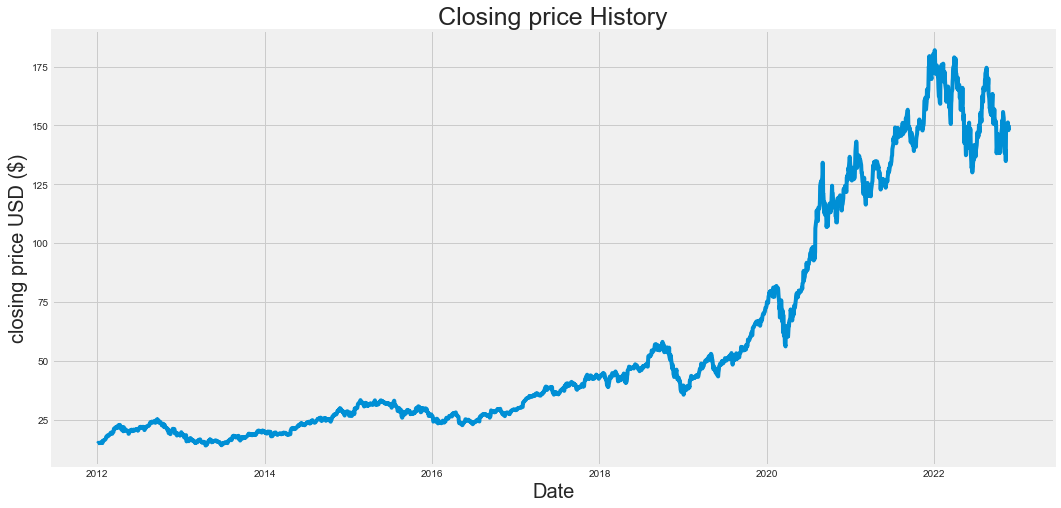

In [6]:
#lets look at the stock closing price of history
import seaborn as sns
plt.figure(figsize=(16,8))
sns.lineplot(x= APPL_data.index,y=APPL_data['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('closing price USD ($)',fontsize=20)
plt.title('Closing price History',fontsize=25)

#### I am using the AAPL dataset, which is already divided into training set and test set, but you can do the divison with a simple command!

In [7]:
# Split into train and test:
data_to_train = APPL_data[:1530]
data_to_test = APPL_data[1530:]

In [8]:
#Now, we can save the 2 csv files, Train and Test.
data_to_train.to_csv('train_data.csv')
data_to_test.to_csv('test_data.csv')

In [9]:
aapl_data= APPL_data.iloc[: , 3:4]
aapl_data.head()

,Close
Date,
2012-01-03,14.686786
2012-01-04,14.765714
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786


In [10]:
## We want to create a numpy arrary not a vector 
trainig_set= aapl_data.iloc[:1530,:].values


In [11]:
test_set= aapl_data.iloc[1530:,:].values


#### It’s a good idea to normalize the data before model fitting. This will boost the performance.

In [12]:
# Feature scalling, Here we will do normalizatioin 
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
trainig_set_scaled= sc.fit_transform(trainig_set)

#### After scaling the training data, we must format it into a three-dimensional array for use in our LSTM model. We accomplish this by generating 60 timestamps.

In [13]:
# Create a data structure with 60 timesteps and 1 output
X_train=[] #Independent variables
y_train= [] # Dependent variables 
# I am going to append past 60 days data 
for i in range(60,1530):
    X_train.append(trainig_set_scaled[i-60:i,0]) # Appending prevois 60 days data not including 60
    y_train.append(trainig_set_scaled[i,0])
    
X_train, y_train= np.array(X_train), np.array(y_train)


In [14]:
# lETS CHECK THE SHAPE OF X_train and y_train
X_train.shape, y_train.shape

((1470, 60), (1470,))

#### We have now reshaped the data into the following format (values, time-steps, 1 dimensional output).

In [15]:
# LSMT Model needs to be 3- dimensional, so need to rehsape the x_train, y_train
# Reshaping
#numpy.reshape(array, shape, order = 'C')
X_train= np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1470, 60, 1)

#### Now, it’s time to build the model. We will build the LSTM with 100 neurons and 5 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the MSE loss function and the Adam stochastic gradient descent optimizer.

In [16]:
# Importing the Keras libraries and packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#  Initialising the RNN
model= Sequential()

# Adding first LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(rate=0.2))

# Adding second LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

# Adding third LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

# Adding fourth LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

# Adding fifth LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100))
model.add(Dropout(rate=0.2))

# Adding the Output Layer
model.add(Dense(units=1))

# Compiling the Model
# Because we're doing regression hence mean_squared_error
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 100)           8

**We use Dropout layers to avoid Overfitting problems, and besides that, we use the parameter “return_sequences” to determine if the layer will return a sequence compatible with a LSTM. We use “return_sequences=True” when we have a LSTM layer after**

In [18]:
# Fitting the model to the Training set
history=model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
46/46 [==============================] - 13s 144ms/step - loss: 0.0225
Epoch 2/100
46/46 [==============================] - 6s 135ms/step - loss: 0.0039
Epoch 3/100
46/46 [==============================] - 6s 131ms/step - loss: 0.0035
Epoch 4/100
46/46 [==============================] - 6s 128ms/step - loss: 0.0033
Epoch 5/100
46/46 [==============================] - 6s 125ms/step - loss: 0.0028
Epoch 6/100
46/46 [==============================] - 6s 133ms/step - loss: 0.0028
Epoch 7/100
46/46 [==============================] - 7s 145ms/step - loss: 0.0030
Epoch 8/100
46/46 [==============================] - 7s 143ms/step - loss: 0.0027
Epoch 9/100
46/46 [==============================] - 8s 167ms/step - loss: 0.0028
Epoch 10/100
46/46 [==============================] - 7s 155ms/step - loss: 0.0032
Epoch 11/100
46/46 [==============================] - 7s 150ms/step - loss: 0.0027
Epoch 12/100
46/46 [==============================] - 7s 152ms/step - loss: 0.0022
Epoch 13/100

46/46 [==============================] - 6s 130ms/step - loss: 7.3986e-04
Epoch 99/100
46/46 [==============================] - 6s 130ms/step - loss: 8.0984e-04
Epoch 100/100
46/46 [==============================] - 6s 130ms/step - loss: 8.8903e-04


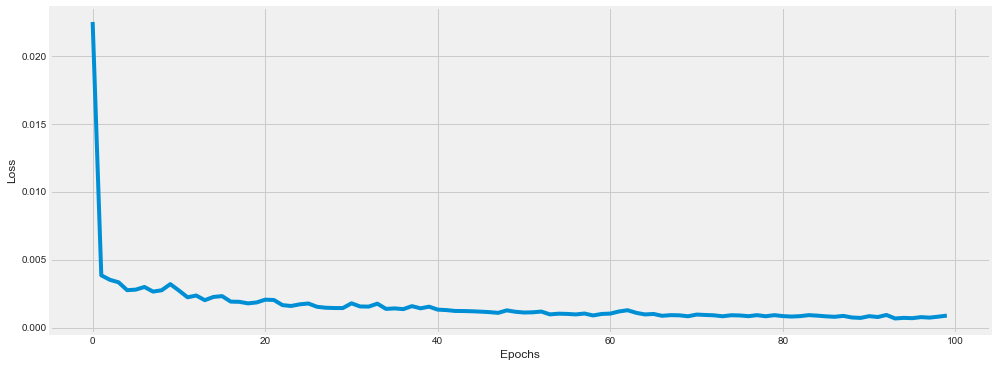

In [19]:
# Evaluating The Model
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


## Making Predictions
To make predictions, we need to use our Test Dataset and format him like we did in the Train Dataset before.

In [20]:
#GEtting ready both train and est data set
train_data= pd.read_csv('train_data.csv')
test_data= pd.read_csv('test_data.csv')

In [21]:
real_stock_price = test_data.iloc[:, 3:4].values

In [22]:
real_stock_price.shape

(1212, 1)

In [23]:
test_set.shape

(1212, 1)

In [24]:
# Hence we will concatenate the dataset and then scale them
data_total= pd.concat([train_data['Close'], test_data['Close']],  axis=0)
inputs= data_total[len(data_total)-len(test_data)-60:].values 
inputs = inputs.reshape(-1,1) 
inputs = sc.transform(inputs)

X_test = []
# y_test = data_total[training_data_len:, :] ################################################
for i in range(60, 230):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
# 3D format
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [25]:
inputs.shape

(1272, 1)

In [26]:
data_total.shape

(2742,)

In [27]:
X_test.shape

(170, 60, 1)

#### After format the Test Data, we can make predictions in our X_test.

In [28]:
#preict the model
predicted_stock_price = model.predict(X_test)

6/6 [==============================] - 2s 38ms/step


#### But before plot our predictions, we need to make a inverse_transform() in the predictions array, because we make predictions using the Scale, so our predictions are between 0 and 1.

In [29]:
# Inverse the scaling
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [34]:
# Get the root mean squared error (RMSE)          #####################################################################
rmse = np.sqrt(np.mean(((predicted_stock_price - real_stock_price) ** 2)))
rmse

ValueError: operands could not be broadcast together with shapes (170,1) (1212,1) 

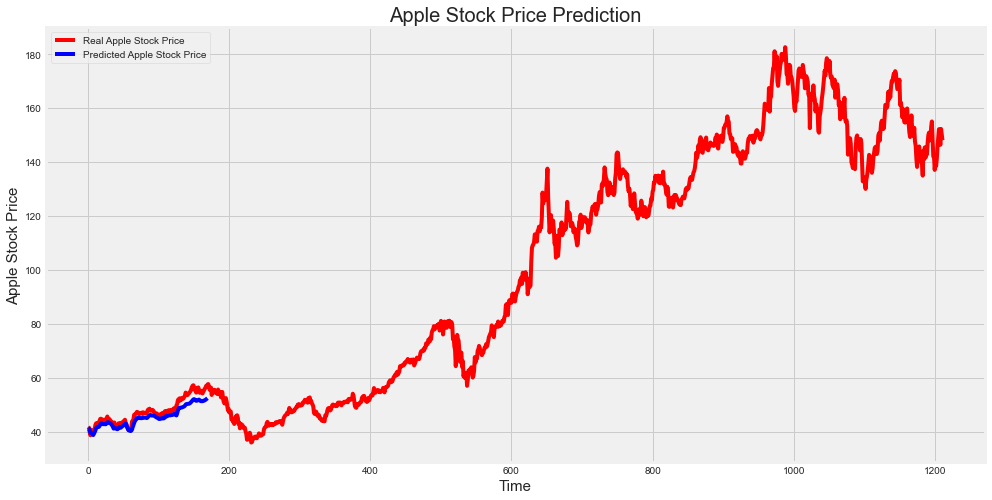

In [30]:
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(real_stock_price, color='Red', label='Real Apple Stock Price')
plt.plot(predicted_stock_price, color='Blue', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction',fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Apple Stock Price',fontsize=15)
plt.legend()
plt.show()

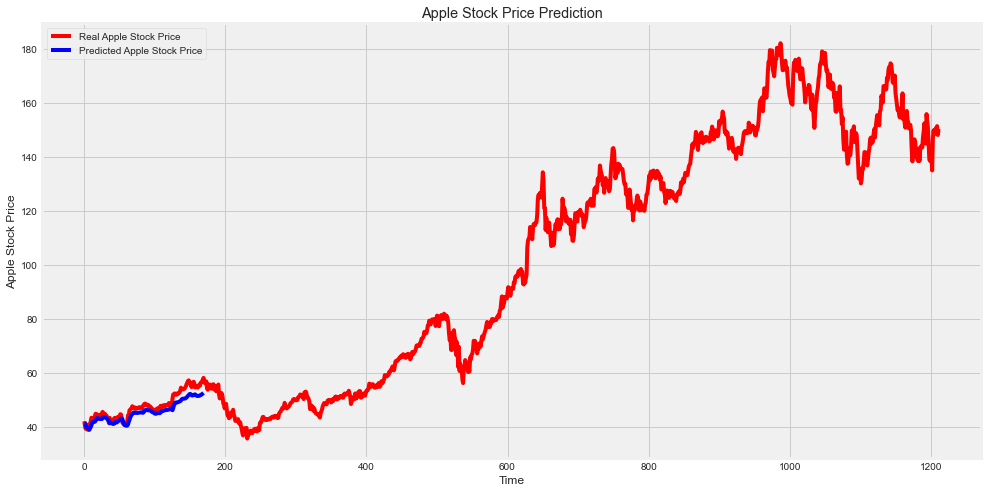

In [31]:
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(test_set, color='Red', label='Real Apple Stock Price')
plt.plot(predicted_stock_price, color='Blue', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

### Conclusion:

Our model performed admirably, as can be seen. It can accurately follow most unusual jumps/drops; however, we can observe that the model expected (predicted) lower values than the actual stock price for the most recent date stamps.